In [1]:
from matplotlib import pyplot as plt
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit_ode import solve_lmde
from qiskit_ode.signals import Signal
from qiskit_ode.models import HamiltonianModel

# In this demo

We show how `qiskit_ode` can be used with the `jax` backend to perform transformations like just-in-time compiling and gradient computation.

In [2]:
from qiskit_ode import dispatch
from qiskit_ode.dispatch import Array
from jax import config
import jax

jit = dispatch.wrap(jax.jit, decorator=True)
grad = dispatch.wrap(jax.grad, decorator=True)

config.update("jax_enable_x64", True)

dispatch.set_default_backend('jax')

def gaussian(amp, sig, t0, t):
    # Note: to enforce using the jax backend for the computation of the gaussian, wrap the
    # input to the numpy function in an Array
    return amp * np.exp( -Array((t - t0)**2 / (2 * sig**2)))

# 1. `jit`: Just-in-time compiling a parameterized simulation

Here we show we can speed up a parameterized simulation through just-in-time compiling. This is useful in situations such as:
- Simulating a variety of pulses in a parameterized family
- Simulating a system over a range of model parameters

One way to do this is the following. First, construct a model with just operators.

In [3]:
#####################
# construct operators
#####################
r = 0.5
w = 1.
X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

operators = [2 * np.pi * w * Z/2, 
             2 * np.pi * r * X/2]

#####################################
# construct model with just operators
#####################################

hamiltonian = HamiltonianModel(operators=operators)

Next, define a function which takes the simulation input parameters and outputs the results. In this case, we parameterize a gaussian drive pulse, set it into the model, then solve and return the results.

*Important note*:
- When applying `jax` transformations, it is important to ensure the function is _pure_, i.e. it has no side effects. As we need to set the signals into the model, to keep the function pure we first make a copy.

Additional note:
- The `solve` function will automatically use the `scipy` solver. To make the full function jax compatible, we must specify a jax solver. Here `jax_odeint` is the equivalent of the `DOP853` algorithm in `scipy`.

In [4]:
def sim_function(amp, sig):
    
    # define signals from parameters
    t0 = 3.5*sig
    T = 7*sig
    gaussian_envelope = lambda t: gaussian(amp, sig, t0, t)
    signals = [1., 
               Signal(envelope=gaussian_envelope, carrier_freq=w)]
    
    # make copy and set signals
    ham_copy = hamiltonian.copy()
    ham_copy.signals = signals
    ham_copy.frame = ham_copy.drift
    
    # simulate and return results
    # setting user_frame tells solve that states should be specified and returned in the frame
    # of the drift
    results = solve_lmde(ham_copy, y0=np.array([0., 1.], dtype=complex), t_span=[0,T], 
                         method='jax_odeint', atol=1e-10, rtol=1e-10)
    return results.y[-1]

# default parameters for doing a pi pulse
amp = 1.
sig = 0.399128/r
    

Next, compile the function by calling `jax.jit`.

In [5]:
fast_sim = jit(sim_function)

Run the simulation once.

Note: the function is only compiled when it is called for the first time. Hence, the first call is slower due to this overhead.

In [6]:
%time fast_sim(2*amp, 2*sig).block_until_ready()

CPU times: user 1.08 s, sys: 17.1 ms, total: 1.1 s
Wall time: 1.1 s


Array([3.72961061e-04+0.02743404j, 9.98634213e-01-0.04446282j])

Call a second time:

In [7]:
%time fast_sim(amp, sig).block_until_ready()

CPU times: user 942 µs, sys: 592 µs, total: 1.53 ms
Wall time: 613 µs


Array([6.68013795e-06-0.99861417j, 2.09958256e-03+0.05258639j])

For speed comparison, the same simulation using the `numpy` backend and the corresponding `scipy` solver takes about `200ms`. Hence, the compiled simulation is almost 2 orders of magnitude faster.

# 2. Automatic differentiation

In addition to compilation, `jax` has a variety of function transformations for taking derivatives of functions. The most basic such function is `jax.grad`, which transforms a real scalar-valued function into one that computes its gradient.

To demonstrate this, we modify the simulation function into one that outputs the excited state population (to convert it into something with a real/scalar output).

In [8]:
def excited_state_pop(amp):
    yf = sim_function(amp, sig)
    return np.abs(Array(yf[0]))**2
    

excited_state_pop(amp)

Array(0.99723026)

Next, take the gradient. Here, we also compile the gradient.

In [9]:
excited_state_grad = jit(grad(excited_state_pop))

In [10]:
%time excited_state_grad(2 * amp).block_until_ready()

CPU times: user 2.84 s, sys: 41.2 ms, total: 2.89 s
Wall time: 2.88 s


Array(-0.03250497)

In [11]:
%time excited_state_grad(amp).block_until_ready()

CPU times: user 1.97 ms, sys: 788 µs, total: 2.76 ms
Wall time: 1.52 ms


Array(-0.00128185)

Note: the derivative at the default `amp` value is near $0$ as the parameters used are near a $\pi$-pulse, and as such near a maximum of the population function.

# 3. State tracking

Our wrapper for the `jax` integrators also supports the `t_eval` argument in the style of `scipy`'s `solve_ivp`. We can use this argument to view the state of the solution over an interval.

Note: if `t_eval` is included, both `t_span` and `t_eval` will be handled with pure numpy, and so compilation will treat `t_span` as a static parameter.

In [12]:
def sim_function(amp):
    
    # define signals from parameters
    sig = 0.399128/r
    t0 = 3.5*sig
    T = 7*sig
    gaussian_envelope = lambda t: gaussian(amp, sig, t0, t)
    signals = [1., 
               Signal(envelope=gaussian_envelope, carrier_freq=w)]
    
    # make copy and set signals
    ham_copy = hamiltonian.copy()
    ham_copy.signals = signals
    ham_copy.frame = ham_copy.drift
    
    # simulate and return results
    # setting user_frame tells solve that states should be specified and returned in the frame
    # of the drift
    results = solve_lmde(ham_copy, y0=np.array([0., 1.], dtype=complex), t_span=[0,T], 
                         t_eval=np.linspace(0, T, 100), method='jax_odeint', atol=1e-10, rtol=1e-10)
    return results.y.data

In [13]:
jitted = jit(sim_function)

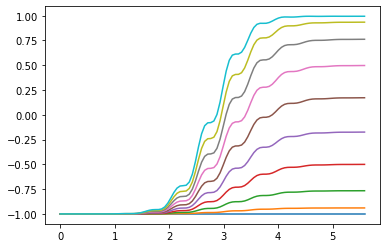

In [14]:
T = 7 * 0.399128 / r

for amp in np.linspace(0, 1, 10):
    ys = jitted(amp)
    plt.plot(np.linspace(0, T, 100), np.real(np.abs(ys[:, 0])**2-np.abs(ys[:, 1])**2))

In the above oscillatory behaviour is due to the RWA not being entirely accurate in this system.